# Úloha dynamického skladování

Optimalizace nákupu a skladování je klíčová v mnoha odvětvích, kde mohou efektivní logistické strategie výrazně snižovat náklady a zvyšovat operační efektivitu. Dynamické programování poskytuje robustní rámec pro řešení těchto komplexních optimalizačních problémů tím, že rozkládá rozhodovací proces na sérii jednodušších kroků. Tato seminární práce se zaměřuje na využití dynamického programování k určení optimálních časů pro nákup a skladování sledovaných produktů, tak aby byly minimalizovány celkové náklady. Algoritmus bude demonstrován na reálných datech získaných z databáze Kaggle, což umožní praktické použití teoretických konceptů.

## Algoritmus

Problém je modelován s využitím následujících proměnných:

- $N_{i,j}$: &nbsp; Náklady na skladování produktů zakoupených v období $i$ a skladovaných až do období $j$.
- &nbsp; $F_{j \,}$: &nbsp; Kumulativní minimální náklady na nákup a skladování produktu až do období $j$.
- &nbsp; $ \, \,c_1$: &nbsp; Náklady na skladování jednoho kusu zboží.
- &nbsp; $ \, \,c_2$: &nbsp; Fixní náklady na realizaci jednoho nákupu zboží.

### Výpočetní matice $N$
Matice $N_{i,j}$ obsahuje náklady spojené s nákupem a skladováním zboží od období $i$ do období $j$. Pro každé období od $i$ do $j$ se spočítají náklady na skladování založené na kumulativní poptávce $p_{i,j}$ až do období $k$, a přidají se fixní náklady $c_2$ na nákup v období $i$, pokud je to relevantní:
\begin{aligned}
   p_{i,j} &= \sum_{m=i}^{j}(d_{m}) \\
   N_{i,j} &= c_1 \cdot \sum_{k=i}^{j}\left (p_{i,j} - \sum_{n=i}^{k}(d_{n}) \right ) + c_2 
\end{aligned}

### Výpočetní rovnice kumulativních nákladů $F$:

Klíčové rovnice použité v algoritmu:

- $F_{j} = \min_{i \leq j} (N_{i,j-1} + F[i])$

Tato rovnice iterativně vyhodnocuje minimální náklady pro každé období $j$ s ohledem na všechna předchozí období $i$, což umožňuje dynamicky aktualizovat nejlepší rozhodnutí na základě předchozích výsledků.

### Zpětné trasování

Po výpočtu minimálních nákladů pro každé období, algoritmus používá zpětné trasování k identifikaci optimální sekvence nákupů:

- Začínáme od posledního období a sledujeme zpět k období, kde byl realizován nákup, který přispěl k minimálním celkovým nákladům.

## Implementace

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def calculate_storage_costs(d: list[int], c1: int | float, c2: int | float) -> tuple[list, list, int | float]:
    """
    Optimalizace nákladů na nákup a skladování zboží

    Args:
        d (list[int]): poptávka za časové období
        c1 (int | float): skladovací náklady za jednu jednotku zboží na jednotku času
        c2 (int | float): fixní náklady pro nákup zboží

    Returns:
        tuple[list, list, int | float]:
            Kumulativní matice nákladů N
            Plán nákupů (kdy nakoupit, na jak dlouho, kolik)
            Celkové náklady
    """
    # Inicializace tabulky nákladů N
    n = len(d)
    N = [[0 if i == j else float('inf') for j in range(n)] for i in range(n)]
        
    # Výpočet nákladů pro každý možný interval nákupů
    for i in range(n):  # startovací období nákupu
        accumulated_demand = 0
        for j in range(i, n):  # koncové období
            accumulated_demand += d[j]
            if i == j:
                # náklady pro první období, kdy se nakupuje
                N[i][j] = c1 * (accumulated_demand - d[j])  # náklady na skladování
                if d[i] > 0: # fixní náklady pokud se v daném období nakupuje
                    N[i][j] += c2
            else:
                # celková akumulovaná poptávka až do období j
                storage_costs = c1 * sum(accumulated_demand - sum(d[i:k+1]) for k in range(i, j))
                N[i][j] = c2 + storage_costs  # fixní náklady + skladovací náklady

    # Příprava tabulky pro kumulativní náklady a trasování
    f = [float('inf')] * (n + 1)
    trace = [-1] * (n + 1)

    # Výpočet optimálních kumulativních nákladů
    f[0] = 0 # nenakupuje se nic před prvním obdobím
    for j in range(1, n + 1):
        for i in range(j):
            potential_cost = N[i][j - 1] + f[i]
            if potential_cost < f[j]:
                f[j] = potential_cost
                trace[j] = i
    
    # Zpětný průchod k nalezení optimálního plánu
    optimal_plan = []
    current = n
    while current > 0:
        start = trace[current]
        optimal_plan.append((start + 1, current, N[start][current-1])) # přidání 1 pro čitelný formát
        current = start

    return N, optimal_plan[::-1], f[n] # obrátíme plán pro chronologické pořadí

In [4]:
# parametry
d = [75, 0, 33, 28, 0, 10] # poptávka (demand)
c1 = 1 # náklady na skladování jedné jednotky
c2 = 110 # fixní náklady

# Výpočet nákladů a optimalizace
cost_table, optimal_plan, optimal_costs = calculate_storage_costs(d, c1, c2)
print(f"Tabulka nákladů:")
for row in cost_table:
    for num in row:
        print(f"{num:3.0f}", end=" ")
    print()
print()
print(f"Optimální plán: {optimal_plan}\nOptimální cena: {optimal_costs}")

Tabulka nákladů:
110 110 176 260 260 310 
inf   0 143 199 199 239 
inf inf 110 138 138 168 
inf inf inf 110 110 130 
inf inf inf inf   0 120 
inf inf inf inf inf 110 

Optimální plán: [(1, 2, 110), (3, 6, 168)]
Optimální cena: 278


## Příklad na reálných datech
Použitý [dataset](https://www.kaggle.com/datasets/missionjee/car-sales-report?resource=download) obsahuje data z prodejů různých značek aut v jednotlivých měsících po dobu 2 let. V následujícím příkladu je porovnána náhodná strategie nákupů a skladování s optimální.

In [5]:
# Načtení a zpracování dat o prodejích automobilů
df = pd.read_csv('car_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Month_Year'] = df['Date'].dt.to_period('M')
pivot_table = df.pivot_table(index='Company', columns='Month_Year', aggfunc='size', fill_value=0)

pivot_table.head(10)

Month_Year,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
Company,,,,,,,,,,,,,,,,,,,,,
Acura,10,14,24,25,26,17,17,24,35,21,...,22,20,27,24,29,27,58,25,59,58
Audi,6,5,17,19,14,7,10,16,33,21,...,14,17,26,23,17,13,36,19,39,35
BMW,11,13,26,40,23,20,24,18,46,22,...,36,29,40,31,30,23,61,41,68,60
Buick,6,7,10,12,14,10,14,9,28,16,...,15,14,25,21,17,20,28,22,29,32
Cadillac,9,9,15,18,18,23,18,16,38,27,...,28,18,32,31,18,29,60,28,44,52
Chevrolet,22,20,48,52,58,52,54,64,114,61,...,56,72,97,71,78,71,146,68,147,151
Chrysler,14,13,39,34,42,32,36,32,75,41,...,38,34,60,43,63,42,86,50,83,82
Dodge,18,25,45,57,33,44,36,55,110,53,...,49,66,95,69,66,63,146,72,119,134
Ford,22,22,45,52,39,54,51,59,93,67,...,67,49,68,73,75,56,133,64,114,135


In [6]:
def random_purchases(pivot_table, brand, c1, c2):
    # Získání dat pro specifickou značku
    brand_data = pivot_table.loc[brand]
    
    # Získání unikátních měsíců
    unique_months = brand_data.index
    results = []
    current_index = 0

    while current_index < len(unique_months):
        # Náhodně zvolit počet měsíců pro nákup
        num_months = np.random.randint(1, min(7, len(unique_months) - current_index) + 1)
        start_month = unique_months[current_index]
        end_month = unique_months[current_index + num_months - 1]

        # Simulace nákladů
        selected_months = brand_data[start_month:end_month]
        accumulated_demand = selected_months.sum()  # Celkový počet jednotek zakoupených v období
        
        # Příklad výpočtu skladovacích nákladů
        storage_costs = c1 * sum([accumulated_demand - sum(brand_data[start_month:start_month+k]) for k in range(num_months)])
        # Uložení výsledků
        results.append((current_index + 1, current_index + num_months, storage_costs + c2 if accumulated_demand > 0 else 0))

        # Posun na další období
        current_index += num_months

    return results, sum([r[-1] for r in results])

In [7]:
# Příklad použití
# Predpokládejme, že pivot_table byla již vytvořena a obsahuje data
c1 = 1 # náklady na skladování jedné jednotky
c2 = 110 # fixní náklady
brand = 'Audi'
random_purchases_strategy, random_cost = random_purchases(pivot_table, brand, 1, 110)
print(random_purchases_strategy, "\n",random_cost)

[(1, 1, 110), (2, 2, 110), (3, 8, 298), (9, 10, 131), (11, 16, 335), (17, 17, 110), (18, 20, 153), (21, 23, 207), (24, 24, 110)] 
 1564


In [8]:
d = list(pivot_table.loc[brand][:])
# Výpočet nákladů a optimalizace
cost_table, optimal_plan, optimal_costs = calculate_storage_costs(d, c1, c2)
print(optimal_plan, "\n", optimal_costs)

[(1, 3, 149), (4, 8, 232), (9, 11, 181), (12, 16, 248), (17, 20, 206), (21, 22, 129), (23, 24, 145)] 
 1290


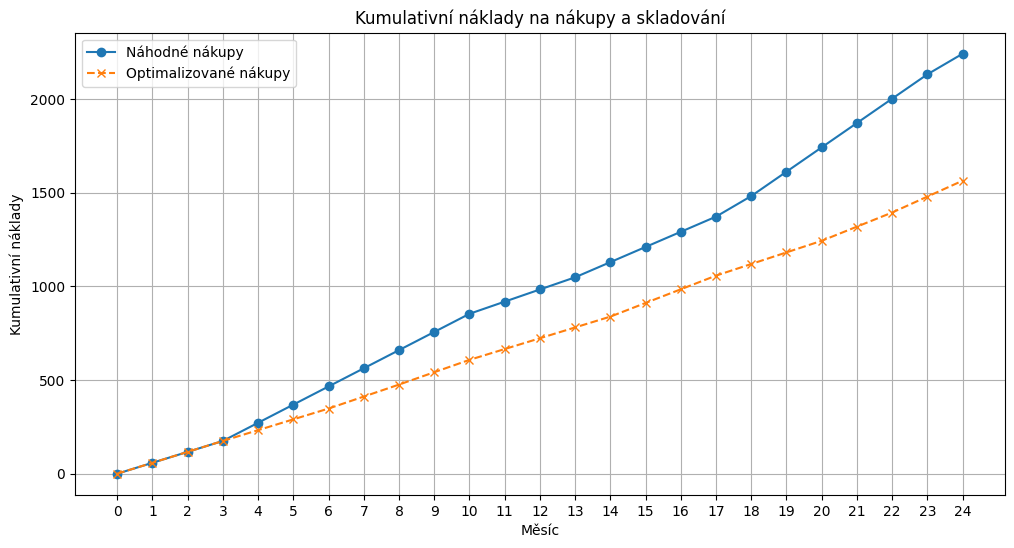

In [10]:
c1 = 1 # náklady na skladování jedné jednotky
c2 = 110 # fixní náklady
brand = 'BMW'
random_purchases_strat, _ = random_purchases(pivot_table, brand, 1, 110)
_, optimized_purchases_strat, _ = calculate_storage_costs(list(pivot_table.loc[brand][:]), c1, c2)

# Převod na kumulativní náklady pro každý měsíc
def convert_to_monthly_costs(purchases):
    costs = {}
    for start, end, cost in purchases:
        # Rozdělit cenu rovnoměrně mezi měsíce
        num_months = end - start + 1
        monthly_cost = cost / num_months
        for month in range(start, end + 1):
            if month in costs:
                costs[month] += monthly_cost
            else:
                costs[month] = monthly_cost
    return costs

random_costs = convert_to_monthly_costs(random_purchases_strat)
optimized_costs = convert_to_monthly_costs(optimized_purchases_strat)

# Vytvoření seznamů pro x (měsíce) a y (náklady) osy
max_month = max(max(random_costs.keys()), max(optimized_costs.keys()))
months = range(max_month + 1)
random_costs_list = [random_costs.get(month, 0) for month in months]
optimized_costs_list = [optimized_costs.get(month, 0) for month in months]

# Kumulativní náklady
random_cumulative = [sum(random_costs_list[:i+1]) for i in range(len(random_costs_list))]
optimized_cumulative = [sum(optimized_costs_list[:i+1]) for i in range(len(optimized_costs_list))]

plt.figure(figsize=(12, 6))
plt.plot(months, random_cumulative, label='Náhodné nákupy', marker='o', linestyle='-')
plt.plot(months, optimized_cumulative, label='Optimalizované nákupy', marker='x', linestyle='--')
plt.title('Kumulativní náklady na nákupy a skladování')
plt.xlabel('Měsíc')
plt.ylabel('Kumulativní náklady')
plt.legend()
plt.grid(True)
plt.xticks(months)  # Zobrazení všech měsíců na osu X
plt.show()
